In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
from wordcloud import WordCloud
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
#load_data
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')

df['CategoryNum'] = df['Category'].map({'ham': 0, 'spam': 1})
df.to_csv('../data/processed/spam_data.csv', index=True)
df.groupby('Category').describe()

CategoryNum                                   
               count mean  std  min  25%  50%  75%  max
Category                                               
ham           4825.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam           747.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [6]:
#Exploratory Data Analysis
#find the number of rows, columns, and missing values
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of missing values: {df.isnull().sum()}")


Number of rows: 5572
Number of columns: 3
Number of missing values: Category       0
Message        0
CategoryNum    0
dtype: int64


Category
ham     4825
spam     747
Name: count, dtype: int64
The percentage of ham messages: 86.59%


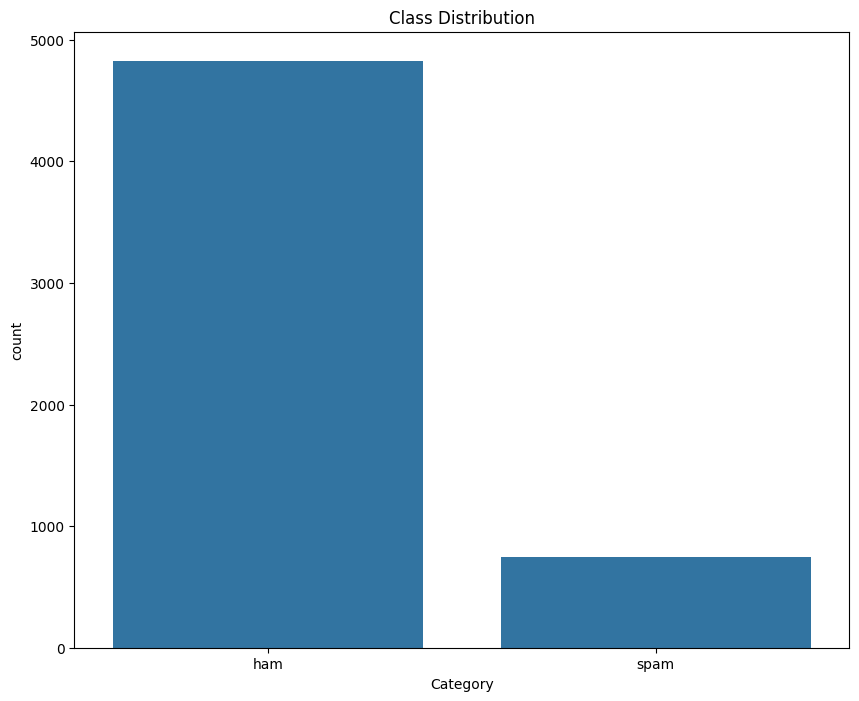

In [7]:
#Class distribution
print(df['Category'].value_counts())

ham_count = df['Category'].value_counts()[0]
spam_count = df['Category'].value_counts()[1]

print(f"The percentage of ham messages: {ham_count / (ham_count + spam_count) * 100:.2f}%")


plt.figure(figsize= (10, 8))
sns.countplot(data=df, x='Category')
plt.title('Class Distribution')
plt.show()

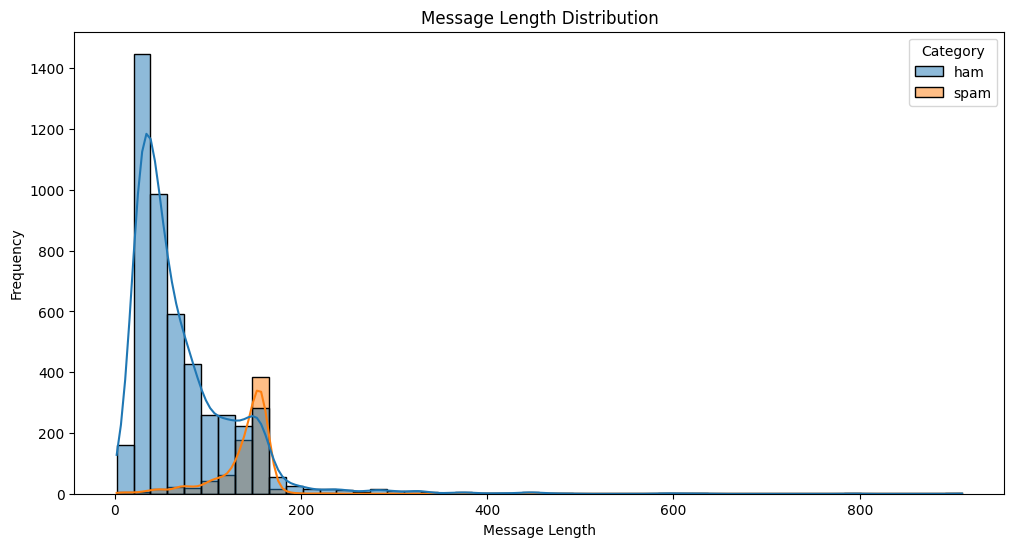

<Figure size 640x480 with 0 Axes>

In [8]:
#Message length distribution
df['Message_Length'] = df['Message'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, bins=50, x='Message_Length', hue='Category', kde=True) 
#hue: tạo biểu đồ phân bố theo loại tin nhắn
#kde: tạo kernel density estimation
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()
plt.savefig('../results/figures/message_length_distribution.png')



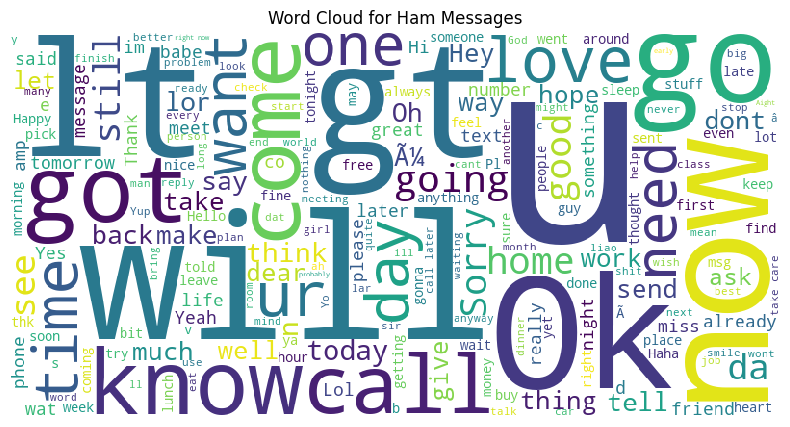

In [9]:
#wordcloud for ham messages
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df[df['Category'] == 'ham']['Message'].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.savefig('../results/figures/wordcloud_ham.png')


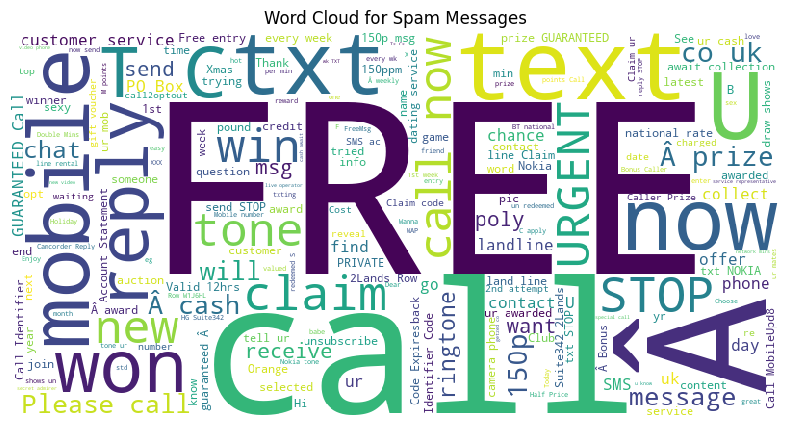

In [10]:

wordcloud = WordCloud(width=800, height=400, background_color= 'white').generate(df[df['CategoryNum'] == 1]['Message'].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.savefig('../results/figures/wordcloud_spam.png')

In [11]:
#Preprocessing
df['Message'] = df['Message'].str.lower()

df['Cleaned_Message'] = df['Message'].str.replace(r'[^a-z0-9\s]', '', regex=True)
df['Cleaned_Message'] = df['Cleaned_Message'].str.split()

stop_words = set(stopwords.words('english'))

df['Cleaned_Message'] = df['Cleaned_Message'].apply(lambda x: [word for word in x if word not in stop_words])


df['Cleaned_Message'] = df['Cleaned_Message'].apply(lambda x: ' '.join(x))
print(df.head())




  Category                                            Message  CategoryNum  \
0      ham  go until jurong point, crazy.. available only ...            0   
1      ham                      ok lar... joking wif u oni...            0   
2     spam  free entry in 2 a wkly comp to win fa cup fina...            1   
3      ham  u dun say so early hor... u c already then say...            0   
4      ham  nah i don't think he goes to usf, he lives aro...            0   

   Message_Length                                    Cleaned_Message  
0             111  go jurong point crazy available bugis n great ...  
1              29                            ok lar joking wif u oni  
2             155  free entry 2 wkly comp win fa cup final tkts 2...  
3              49                u dun say early hor u c already say  
4              61        nah dont think goes usf lives around though  


In [ ]:
#Model training
x,y = df['Cleaned_Message'], df['CategoryNum']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

svm = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm.fit(x_train_tfidf, y_train)

y_pred = svm.predict(x_test_tfidf)

print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred))
print(f"The accuracy of the model is {accuracy_score(y_test, y_pred):.2f}")

svm.score(x_test_tfidf)


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1206
        spam       0.94      0.91      0.92       187

    accuracy                           0.98      1393
   macro avg       0.96      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393

[[1195   11]
 [  17  170]]
The accuracy of the model is 0.98


In [18]:
email_ham = ["hey wanna grab lunch tomorrow?"]
email_ham = tfidf.transform(email_ham)
email_ham_pred = svm.predict(email_ham)
print(email_ham_pred)

[0]


In [19]:
email_spam = ["Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize."]
email_spam = tfidf.transform(email_spam)
email_spam_pred = svm.predict(email_spam)
print(email_spam_pred)

[1]


In [14]:
#grid search cross validation and hyperparameter tuning

grid = {
  'C': [0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'],
}

svm = SVC(random_state=42, probability=True, class_weight='balanced')

grid_search = GridSearchCV(svm, scoring= 'f1', param_grid=grid, cv=None, n_jobs=-1)

grid_search.fit(x_train_tfidf, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)









KeyboardInterrupt: 

In [ ]:
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(x_test_tfidf)

print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred))
print(f"The accuracy of the model is {accuracy_score(y_test, y_pred):.2f}")





              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1206
        spam       0.94      0.91      0.92       187

    accuracy                           0.98      1393
   macro avg       0.96      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393

[[1195   11]
 [  17  170]]
The accuracy of the model is 0.98
